In [1]:
import ciw
import matplotlib.pyplot as plt 
import pandas as pd ,seaborn as sns, numpy as np ,matplotlib.pyplot as plt
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
warnings.filterwarnings('ignore')
# set seed for reproducibility
np.random.seed(0)
#plt.figure(figsize=(20,10))
import matplotlib 
font = {#'family' : 'normal',
        #'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font)

C:\Users\Owner\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Creating Functions

In [2]:
# We will create a function to run the simulations
# and evaluate the performance

def simulate_model(l, mu, c, decimal):
    """ Create a simulation for the model using the given the arrival rate, service rate
        number of servers, and decimal, evaluate the performance.
        Returns the resulting dataframe, the probability df and p0
        
        Parameters:
            - l: arrival rate (float)
            - mu: service rate (float)
            - c: Number of Servers (int)
            - decimal: Decimal places (int)
    """
    
    # Create the simulation
    N = ciw.create_network(
        arrival_distributions=[ciw.dists.Exponential(rate=l)],
        service_distributions=[ciw.dists.Exponential(rate=mu)],
        number_of_servers=[c])
    
    ciw.seed(0)

    Q = ciw.Simulation(N, tracker=ciw.trackers.SystemPopulation())
    Q.simulate_until_max_time(12)


    recs = Q.get_all_records()
    df = pd.DataFrame(recs)
    df.sort_values(by='arrival_date',inplace=True)
    df['inter_arrival'] = df.arrival_date - df.arrival_date.shift(1,fill_value=0)
    df['system_time'] = df.exit_date - df.arrival_date
    
    # Evaluate the Performance (For M/M/1 Models)
    
    avg_inter_arrival_time = df['inter_arrival'].mean()

    avg_service_time = df['service_time'].mean()

    avg_system_time = df['system_time'].mean()

    coefficient_of_variation_arrival = df['inter_arrival'].std()/df['inter_arrival'].mean()

    # Change the coeffficient of service 
    coefficient_of_variation_service = df['service_time'].std()/df['service_time'].mean()

    avg_queue_size = df['queue_size_at_arrival'].mean()

    avg_wait_time = df['waiting_time'].mean()

    idel_time = 1- Q.transitive_nodes[0].server_utilisation

    utilization_rate = Q.transitive_nodes[0].server_utilisation

    # number of customers at any different time
    ts = [ts[0] for ts in Q.statetracker.history]
    n2 = [ts[1] for ts in Q.statetracker.history]

    timeline = pd.DataFrame(list(zip(ts, n2)), columns =['time', 'number_customers'])
    Tn = timeline.groupby(['number_customers'])['time'].count().to_frame('Freq').reset_index()
    
    # If we are working with 2 servers (M/M/2)
    # we will print some additional metrics:
    
    if (c == 2):
        # number of customers at any different time
        ts = [ts[0] for ts in Q.statetracker.history]
        n2 = [ts[1] for ts in Q.statetracker.history]

        timeline = pd.DataFrame(list(zip(ts, n2)), columns =['time', 'number_customers'])
        Tn = timeline.groupby(['number_customers'])['time'].count().to_frame('Freq').reset_index()

        # number of customers distribution
        ts = list(Q.statetracker.state_probabilities().keys())
        n2 = list(Q.statetracker.state_probabilities().values())
        prob_df = pd.DataFrame(list(zip(ts, n2)),
                       columns =['number_cust_system', 'probability_system'])
        idel = 1- Q.transitive_nodes[0].server_utilisation
        p0 = idel

        #computing expected customers waiting in line
        Lq=sum((prob_df.number_cust_system[c+1:])*(prob_df.probability_system[c+1:]))
        Ls=sum((prob_df.number_cust_system)*(prob_df.probability_system))

        ### customer in queue distribution 
        prob_df['number_cust_queue'] = (prob_df['number_cust_system']-c).clip(0, None)
        prod_df_queue = prob_df.groupby('number_cust_queue')['probability_system'].sum().to_frame('probability_queue').reset_index()
        
        # Print the performance results
        print('Output:','\n',
             'Servers : '+str(c),'\n ',
             'Coefficient of Variation Time between Arrival Time:  ' ,str(round(coefficient_of_variation_arrival,decimal)),'\n',
             'Coefficient of Variation Service Time:  ' ,str(round(coefficient_of_variation_service,decimal)),'\n',      
             'Mean Time Between Arrivals : ',str(round(avg_inter_arrival_time,decimal)),'\n',
             'Mean Service Time: ',str(round(avg_service_time,decimal)),'\n'
             ' Utilization (c): ', str(round(Q.transitive_nodes[0].server_utilisation,decimal)),'\n',
              'Probability of No Customers in system(P0): ', str(round(1-Q.transitive_nodes[0].server_utilisation,decimal)),'\n',
             'Expected wait time in line (Wq):',str(round(avg_wait_time,decimal)),'\n',
             'Expected time spent on the system (Ws):',str(round(avg_system_time,decimal)),'\n',
             'Expected number of customers in line (Lq):',str(round(Lq,decimal)),'\n',
             'Expected number of clients in the system (Ls):',str(round(Ls,decimal)),'\n ',
             'Number of customers received service',  len(df))
        
        # return the dataframe, the probability dataframe and p0
        return df, prob_df, p0
    
    else:
    
        # Go back to the M/M/1 model metrics if we are not working with M/M/2

        # number of customers distribution
        ts = list(Q.statetracker.state_probabilities().keys())

        n2 = list(Q.statetracker.state_probabilities().values())

        prob_df = pd.DataFrame(list(zip(ts, n2)),
                       columns =['number_cust_system', 'probability_system'])

        p0 = prob_df['probability_system'][0]

        # Print the performance results
        print('Output:','\n',
             'Servers : '+str(c),'\n',
             'Coefficient of Variation Time between Arrival Time:  ' ,str(round(coefficient_of_variation_arrival,decimal)),'\n',
             'Coefficient of Variation Service Time:  ' ,str(round(coefficient_of_variation_service,decimal)),'\n',
             'Mean Time Between Arrivals: ',str(round(avg_inter_arrival_time,decimal)),'\n',
             'Mean Service Time: ',str(round(avg_service_time,decimal)),'\n'
             ' Utilization (c): ', str(round(utilization_rate,decimal)),'\n',
             'Expected wait time in line (Wq):',str(round(avg_wait_time,decimal)),'\n',
             'Expected time spent on the system (Ws):',str(round(avg_system_time,decimal)),'\n',
             'Expected number of customers in line (Lq):',str(round(avg_queue_size,decimal)),'\n',
             'Probability of No customers in system(P0): ', str(round(p0,decimal)),'\n'
        )


        # Return the simulation dataframe
        return df, prob_df, p0

In [3]:
# We will create another function to plot the results
def plot_times(df):
    """ Given the simulation dataframe, plot the wait times, arrival times, 
        time between arrival distribution, and the service time distribution
        plot.
        
        Parameters:
            - df: Simulation Model (Dataframe)
    """
    
    # Plotting Wait times
    plt.figure(figsize=(12,4))
    sns.lineplot(x=df['id_number'],y=df['service_time'],color='red').set(xticklabels=[])
    plt.xlabel('Customer number')
    plt.ylabel('Hours')
    plt.title('Service Time of Customer')
    sns.despine()
    plt.show()


    # Plotting Arrival times
    plt.figure(figsize=(12,4))
    sns.lineplot(x=df['id_number'],y=df['arrival_date'],color='red').set(xticklabels=[])
    plt.xlabel('Customer number')
    plt.ylabel('Hours')
    plt.title('Arrival Time of Customer')
    sns.despine()
    plt.show()

    # Plot Distribution of Time between Arrivals
    plt.figure(figsize=(12,4))
    sns.distplot(df['inter_arrival'],kde=False,bins=20)
    plt.title('Time between Arrivals Distribution')
    plt.xlabel('Hours')
    plt.ylabel('Frequency')
    sns.despine()
    plt.show()

    # Service time distribution plot
    plt.figure(figsize=(12,4))
    sns.distplot(df['service_time'],kde=False,bins=20)
    plt.title('Service Times Distribution')
    plt.xlabel('Hours')
    plt.ylabel('Frequency')
    sns.despine()
    plt.show()

In [4]:
# Create a function the plot some performance measures of the model

def plot_perform(df, prob_df, p0):
    """ Given the simulation model dataframe, plot some performance 
        measures.
        
        Parameters:
            - df: simulation model (Dataframe)
    """
    
    # Plot Wait time of Customers 
    plt.figure(figsize=(12,4))
    sns.lineplot(x=df['id_number'],y=df['waiting_time'],color='red').set(xticklabels=[])
    plt.xlabel('Customer ID')
    plt.ylabel('Hours')
    plt.title('Wait time of customers')
    sns.despine()
    plt.show()

    # Plot Queue Size at Time of Arrival
    plt.figure(figsize=(12,4))
    sns.lineplot(x=df['arrival_date'],y=df['queue_size_at_arrival'],color='blue').set(xticklabels=[])
    plt.xlabel('Arrival Time')
    plt.ylabel('# of Customers')
    plt.title('Queue Size at Time of Arrival')
    sns.despine()
    plt.show()

    # Plot Probability of n customers in system
    plt.figure(figsize=(12,4))
    sns.barplot(x=prob_df.iloc[0:10,:]['number_cust_system'],y=prob_df.iloc[0:10,:]['probability_system'],color='g')
    plt.title('Probability of n customers in the system')
    plt.xlabel('Number of customers')
    plt.ylabel('Probability')
    sns.despine()
    plt.show()

    # Plot utilitzation of model
    plt.figure(figsize=(12,4))
    plt.bar(['Idle','Occupied'],[p0,1-p0],color='mediumpurple')
    plt.title('Utilization')
    plt.xlabel('System state')
    plt.ylabel('Probability')
    sns.despine()
    plt.show()

# Q2: How busy are the systems in terms of their utilization rates? 

# London M/M/1 

#### Simulate the M/M/1 model for London

In [5]:
# Given
london_ar = 109.025 # London patient arrival rate
toronto_ar = 327.259 # Toronto patient arrival rate

london_sr = 110.047 # London patient service rate 
toronto_sr = 327.514 # Toronto patient service rate

In [6]:
# Set the variables

l = london_ar # arrival rate: Average number of patients per year
mu = london_sr # service rate: Average number of donors per year 
c = 1 # Number of servers 
decimal = 4

In [7]:
# Use the simulate model function to 
lon_model, lon_prob_df, lon_p0 = simulate_model(l, mu, c, decimal)
lon_model[['id_number','server_id','arrival_date','waiting_time','service_start_date','server_id','service_time','service_end_date','exit_date','queue_size_at_arrival','queue_size_at_departure']]

Output: 
 Servers : 1 
 Coefficient of Variation Time between Arrival Time:   1.0067 
 Coefficient of Variation Service Time:   1.0214 
 Mean Time Between Arrivals:  0.0094 
 Mean Service Time:  0.0091 
 Utilization (c):  0.944 
 Expected wait time in line (Wq): 0.1277 
 Expected time spent on the system (Ws): 0.1368 
 Expected number of customers in line (Lq): 13.9366 
 Probability of No customers in system(P0):  0.056 



,id_number,server_id,arrival_date,waiting_time,service_start_date,server_id,service_time,service_end_date,exit_date,queue_size_at_arrival,queue_size_at_departure
0,1,1,0.017066,0.000000,0.017066,1,0.012891,0.029957,0.029957,0,2
1,2,1,0.022071,0.007886,0.029957,1,0.004717,0.034674,0.034674,1,2
2,3,1,0.024820,0.009854,0.034674,1,0.003284,0.037958,0.037958,2,1
3,4,1,0.031387,0.006572,0.037958,1,0.005883,0.043841,0.043841,2,0
4,5,1,0.045434,0.000000,0.045434,1,0.007956,0.053391,0.053391,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1242,1243,1,11.716779,0.221351,11.938130,1,0.043825,11.981955,11.981955,29,26
1243,1244,1,11.718327,0.263628,11.981955,1,0.000549,11.982504,11.982504,30,25
1244,1245,1,11.719803,0.262701,11.982504,1,0.003678,11.986182,11.986182,31,24
1245,1246,1,11.727600,0.258582,11.986182,1,0.009215,11.995396,11.995396,30,26


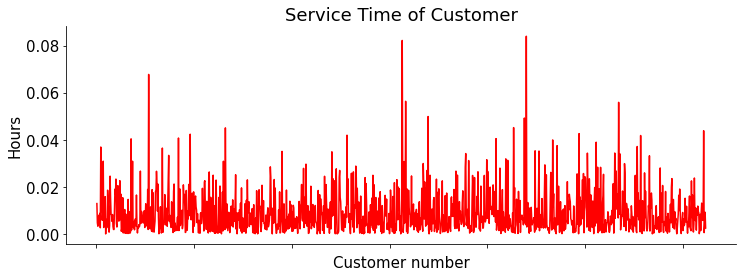

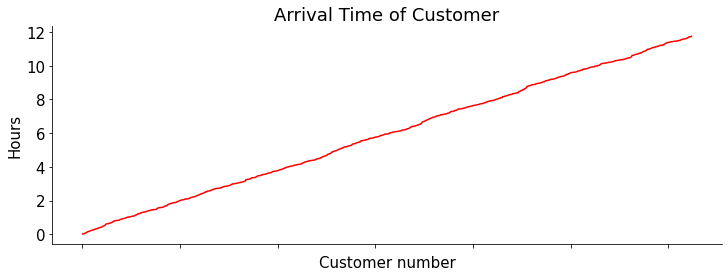

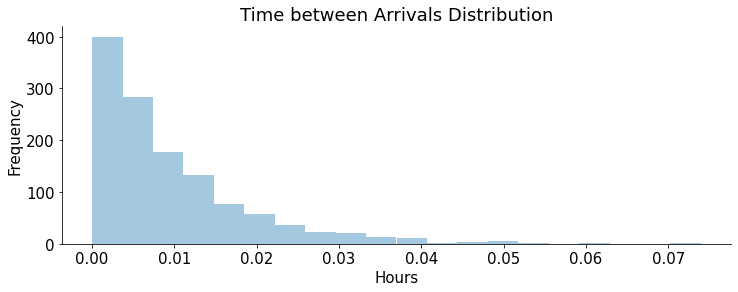

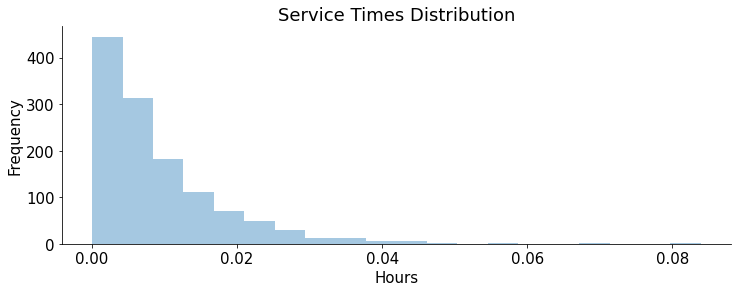

In [8]:
# Plot
plot_times(lon_model)

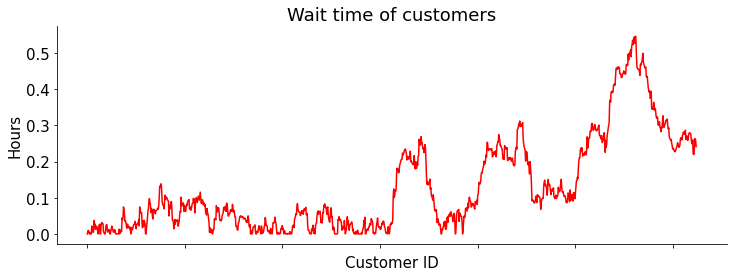

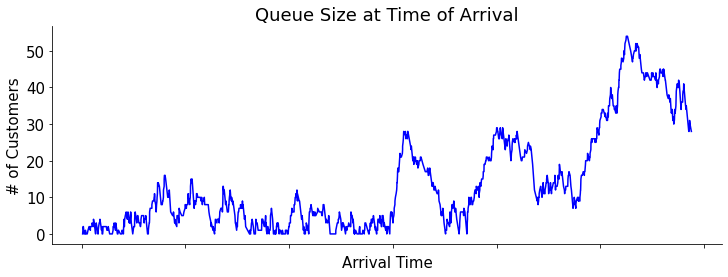

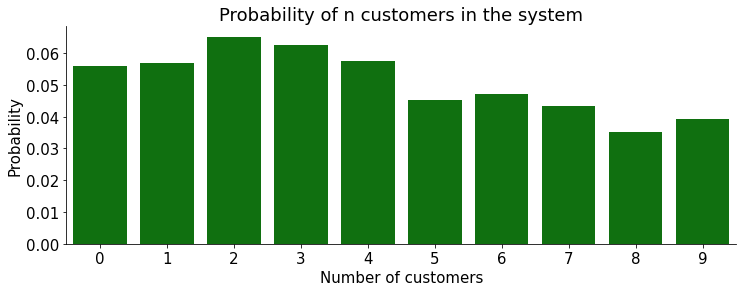

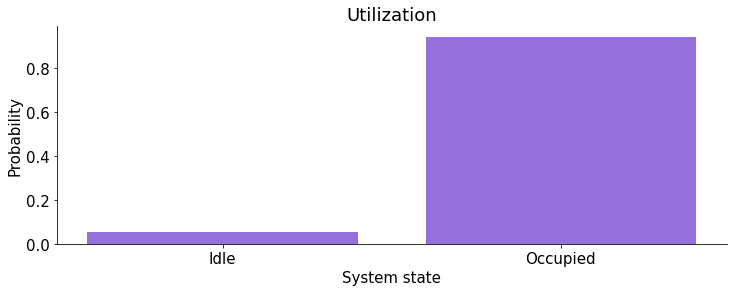

In [9]:
# Plot the performance 
plot_perform(lon_model, lon_prob_df, lon_p0)

# Toronto M/M/1

In [10]:
# Set the variables
l = toronto_ar # arrival rate: Average number of patients per year
mu = toronto_sr # service rate: Average number of donors per year 
c = 1 # Number of servers 
decimal = 4

In [11]:
# Use the simulate model function to 
tor_model, tor_prob_df, tor_p0 = simulate_model(l, mu, c, decimal)
tor_model[['id_number','server_id','arrival_date','waiting_time','service_start_date','server_id','service_time','service_end_date','exit_date','queue_size_at_arrival','queue_size_at_departure']]

Output: 
 Servers : 1 
 Coefficient of Variation Time between Arrival Time:   1.0203 
 Coefficient of Variation Service Time:   0.9556 
 Mean Time Between Arrivals:  0.003 
 Mean Service Time:  0.0031 
 Utilization (c):  0.994 
 Expected wait time in line (Wq): 0.2682 
 Expected time spent on the system (Ws): 0.2713 
 Expected number of customers in line (Lq): 86.8885 
 Probability of No customers in system(P0):  0.006 



,id_number,server_id,arrival_date,waiting_time,service_start_date,server_id,service_time,service_end_date,exit_date,queue_size_at_arrival,queue_size_at_departure
0,1,1,0.005685,0.000000,0.005685,1,0.004332,0.010017,0.010017,0,2
1,2,1,0.007353,0.002664,0.010017,1,0.001585,0.011602,0.011602,1,2
2,3,1,0.008269,0.003333,0.011602,1,0.001104,0.012705,0.012705,2,1
3,4,1,0.010456,0.002249,0.012705,1,0.001977,0.014682,0.014682,2,0
4,5,1,0.015136,0.000000,0.015136,1,0.002673,0.017810,0.017810,0,0
...,...,...,...,...,...,...,...,...,...,...,...
3835,3836,1,11.665579,0.322276,11.987855,1,0.001128,11.988983,11.988983,119,116
3836,3837,1,11.666832,0.322151,11.988983,1,0.000798,11.989781,11.989781,120,116
3837,3838,1,11.669563,0.320218,11.989781,1,0.003548,11.993330,11.993330,121,115
3838,3839,1,11.680354,0.312975,11.993330,1,0.003498,11.996828,11.996828,121,115


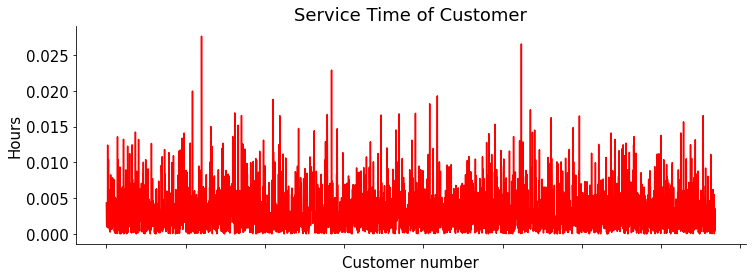

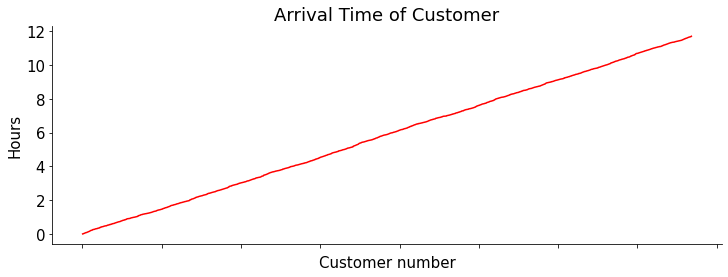

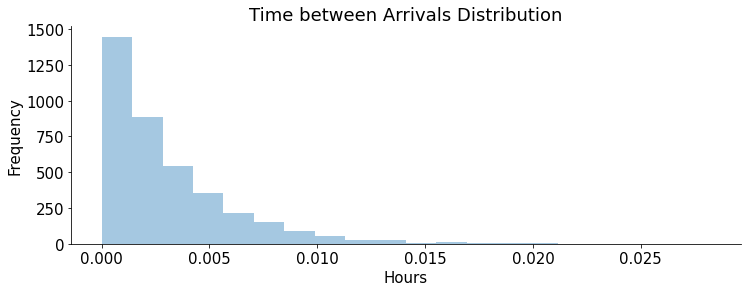

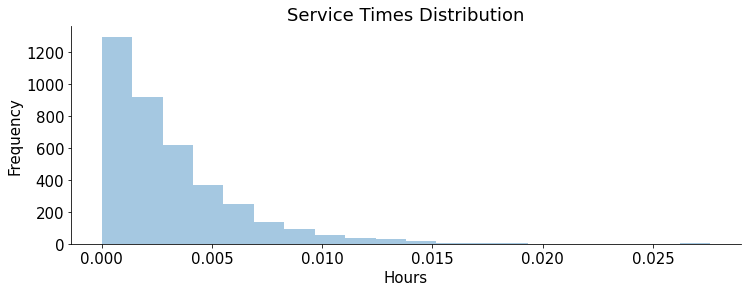

In [12]:
# Plot
plot_times(tor_model)

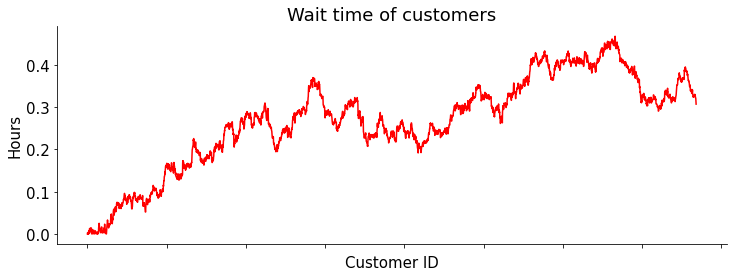

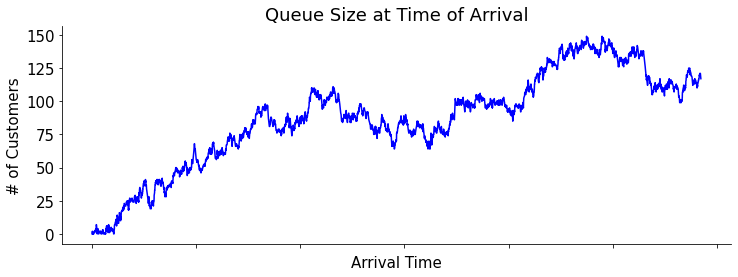

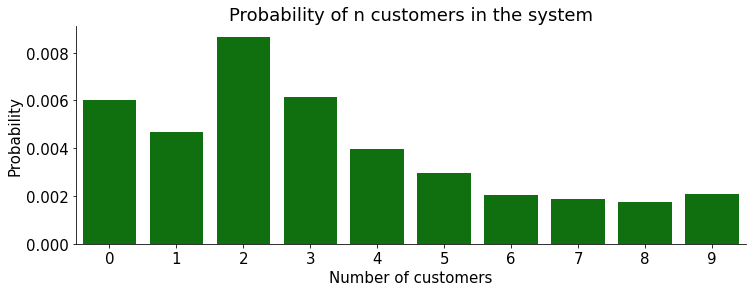

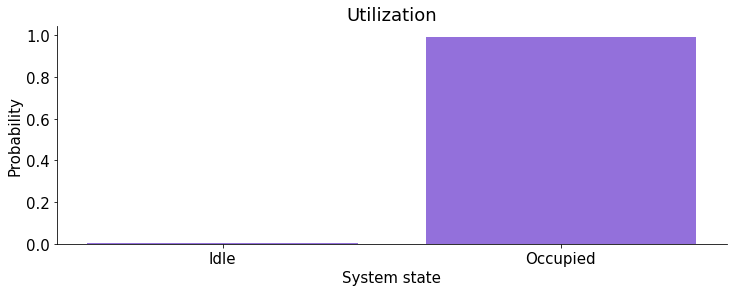

In [13]:
# Plot the performance 
plot_perform(tor_model, tor_prob_df, tor_p0)

# Q3: M/M/1 Pooled Queue

In [14]:
# Given
london_ar = 109.025 # London patient arrival rate
toronto_ar = 327.259 # Toronto patient arrival rate

london_sr = 110.047 # London patient service rate 
toronto_sr = 327.514 # Toronto patient service rate

In [15]:
# Given that the waitlists are combined and we now have 
# two servers with equal rates:

pooled_ar = london_ar + toronto_ar 
pooled_sr = london_sr + toronto_sr
c = 1
decimal = 4

print(pooled_ar, pooled_sr)

436.284 437.56100000000004


In [16]:
# Create simulation and evaluate performance
# of the M/M/2 Combined Queue
pooled_model, pooled_prob_df, pooled_p0 = simulate_model(pooled_ar, pooled_sr, c, decimal)
pooled_model[['id_number','server_id','arrival_date','waiting_time','service_start_date','server_id','service_time','service_end_date','exit_date','queue_size_at_arrival','queue_size_at_departure']]

Output: 
 Servers : 1 
 Coefficient of Variation Time between Arrival Time:   0.9745 
 Coefficient of Variation Service Time:   1.0009 
 Mean Time Between Arrivals:  0.0023 
 Mean Service Time:  0.0023 
 Utilization (c):  0.9917 
 Expected wait time in line (Wq): 0.158 
 Expected time spent on the system (Ws): 0.1603 
 Expected number of customers in line (Lq): 70.6106 
 Probability of No customers in system(P0):  0.0083 



,id_number,server_id,arrival_date,waiting_time,service_start_date,server_id,service_time,service_end_date,exit_date,queue_size_at_arrival,queue_size_at_departure
0,1,1,0.004265,0.000000,0.004265,1,0.003242,0.007507,0.007507,0,2
1,2,1,0.005515,0.001991,0.007507,1,0.001186,0.008693,0.008693,1,2
2,3,1,0.006202,0.002491,0.008693,1,0.000826,0.009519,0.009519,2,1
3,4,1,0.007843,0.001676,0.009519,1,0.001480,0.010999,0.010999,2,0
4,5,1,0.011354,0.000000,0.011354,1,0.002001,0.013355,0.013355,0,0
...,...,...,...,...,...,...,...,...,...,...,...
5226,5227,1,11.869355,0.112536,11.981891,1,0.001966,11.983857,11.983857,57,48
5227,5228,1,11.873427,0.110431,11.983857,1,0.000462,11.984319,11.984319,54,47
5228,5229,1,11.876096,0.108223,11.984319,1,0.002190,11.986509,11.986509,54,48
5229,5230,1,11.878335,0.108174,11.986509,1,0.000672,11.987182,11.987182,51,47


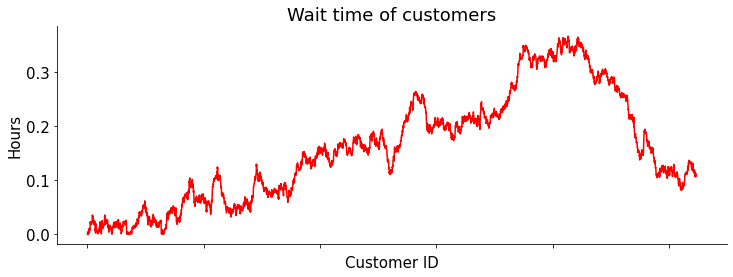

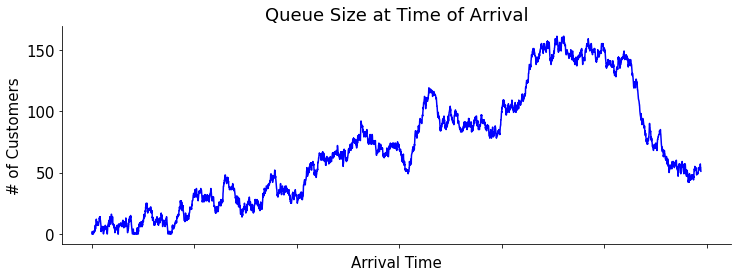

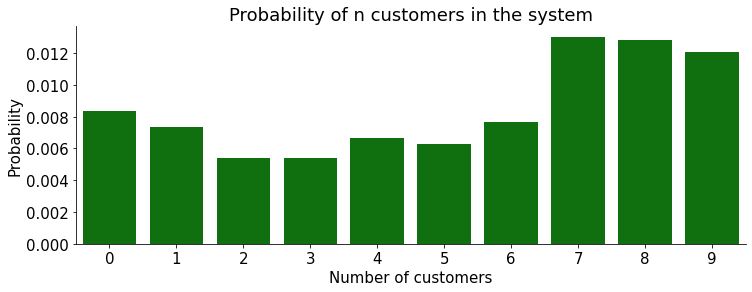

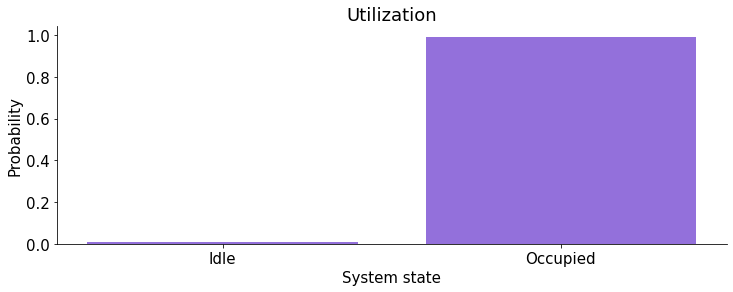

In [17]:
# Plot the performance measures of the model
plot_perform(pooled_model, pooled_prob_df, pooled_p0)

# Q4a: M/M/2 Combined Queue

In [18]:
# Given
london_ar = 109.025 # London patient arrival rate
toronto_ar = 327.259 # Toronto patient arrival rate

london_sr = 110.047 # London patient service rate 
toronto_sr = 327.514 # Toronto patient service rate

In [19]:
# Given that the waitlists are combined and we now have 
# two servers with equal rates:

combined_ar = london_ar + toronto_ar
new_sr = (london_sr + toronto_sr)/2 
c = 2
decimal = 4

print(combined_ar, new_sr)

436.284 218.78050000000002


In [20]:
# Create simulation and evaluate performance
# of the M/M/2 Combined Queue
combined_model, com_prob_df, com_p0 = simulate_model(combined_ar, new_sr, c, decimal)
combined_model[['id_number','server_id','arrival_date','waiting_time','service_start_date','server_id','service_time','service_end_date','exit_date','queue_size_at_arrival','queue_size_at_departure']]

Output: 
 Servers : 2 
  Coefficient of Variation Time between Arrival Time:   0.9774 
 Coefficient of Variation Service Time:   0.9981 
 Mean Time Between Arrivals :  0.0023 
 Mean Service Time:  0.0045 
 Utilization (c):  0.9873 
 Probability of No Customers in system(P0):  0.0127 
 Expected wait time in line (Wq): 0.0756 
 Expected time spent on the system (Ws): 0.0801 
 Expected number of customers in line (Lq): 34.9906 
 Expected number of clients in the system (Ls): 35.0329 
  Number of customers received service 5246


,id_number,server_id,arrival_date,waiting_time,service_start_date,server_id,service_time,service_end_date,exit_date,queue_size_at_arrival,queue_size_at_departure
2,1,1,0.004265,0.000000,0.004265,1,0.006484,0.010749,0.010749,0,1
0,2,2,0.005515,0.000000,0.005515,2,0.001370,0.006885,0.006885,1,1
1,3,2,0.007157,0.000000,0.007157,2,0.002373,0.009529,0.009529,1,1
3,4,2,0.010667,0.000000,0.010667,2,0.001652,0.012319,0.012319,1,1
4,5,1,0.012151,0.000000,0.012151,1,0.004002,0.016153,0.016153,1,0
...,...,...,...,...,...,...,...,...,...,...,...
5242,5242,2,11.970201,0.023089,11.993290,2,0.002273,11.995563,11.995563,14,7
5241,5243,1,11.975956,0.018880,11.994836,1,0.000087,11.994924,11.994924,11,7
5243,5244,1,11.977325,0.017599,11.994924,1,0.001868,11.996791,11.996791,11,7
5244,5245,2,11.977843,0.017720,11.995563,2,0.002251,11.997814,11.997814,12,6


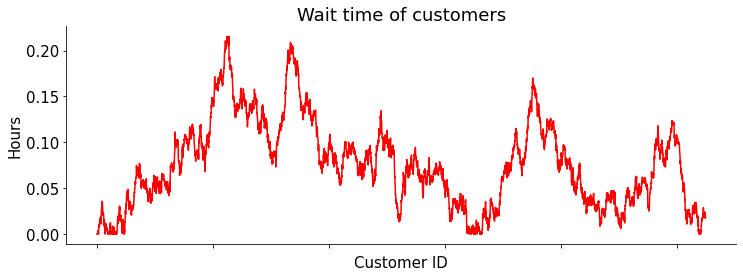

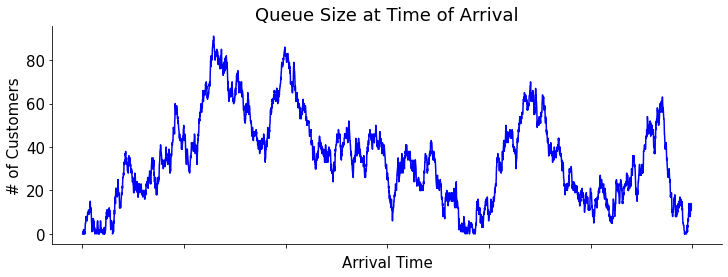

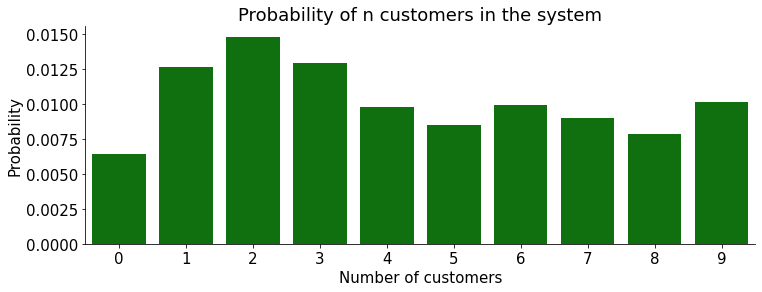

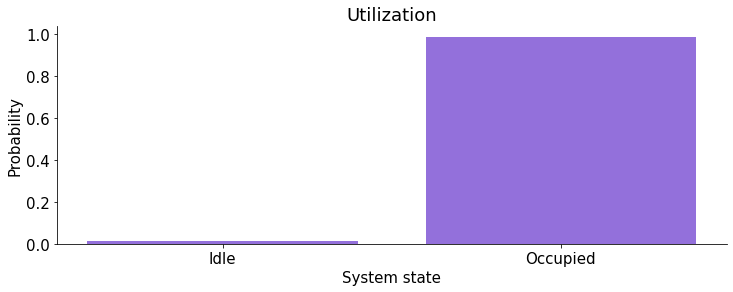

In [21]:
# Plot the performance measures of the model
plot_perform(combined_model, com_prob_df, com_p0)

# 4b: M/M/2 Seperate Lines

In [22]:
# Given two equal M/M/1 queues, we can think of this situation
# as an M/M/2 model with seperate wait lines:
equal_ar = 218.142 # Equal arrival rate for the two M/M/1 queues
equal_sr = 218.78 # Equal service rates for the two M/M/1 queues
c = 1
decimal = 4

In [23]:
# Create the model, prob_df and p0 using the simulate model function
equal_model, eq_prob_df, eq_p0 = simulate_model(equal_ar, equal_sr, c, decimal)
equal_model[['id_number','server_id','arrival_date','waiting_time','service_start_date','server_id','service_time','service_end_date','exit_date','queue_size_at_arrival','queue_size_at_departure']]

Output: 
 Servers : 1 
 Coefficient of Variation Time between Arrival Time:   0.9865 
 Coefficient of Variation Service Time:   1.0117 
 Mean Time Between Arrivals:  0.0046 
 Mean Service Time:  0.0047 
 Utilization (c):  0.9833 
 Expected wait time in line (Wq): 0.1474 
 Expected time spent on the system (Ws): 0.152 
 Expected number of customers in line (Lq): 31.9486 
 Probability of No customers in system(P0):  0.0167 



,id_number,server_id,arrival_date,waiting_time,service_start_date,server_id,service_time,service_end_date,exit_date,queue_size_at_arrival,queue_size_at_departure
0,1,1,0.008529,0.000000,0.008529,1,0.006484,0.015014,0.015014,0,2
1,2,1,0.011031,0.003983,0.015014,1,0.002373,0.017386,0.017386,1,2
2,3,1,0.012405,0.004982,0.017386,1,0.001652,0.019038,0.019038,2,1
3,4,1,0.015687,0.003352,0.019038,1,0.002959,0.021997,0.021997,2,0
4,5,1,0.022708,0.000000,0.022708,1,0.004002,0.026710,0.026710,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2523,2524,1,11.624370,0.355337,11.979707,1,0.003534,11.983241,11.983241,64,65
2524,2525,1,11.628439,0.354803,11.983241,1,0.000576,11.983818,11.983818,65,64
2525,2526,1,11.632614,0.351204,11.983818,1,0.007808,11.991625,11.991625,65,64
2526,2527,1,11.636878,0.354748,11.991625,1,0.003761,11.995386,11.995386,66,63


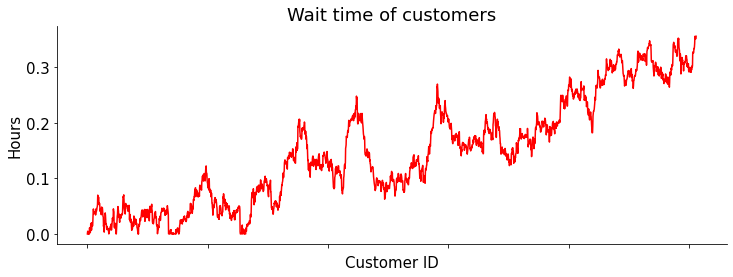

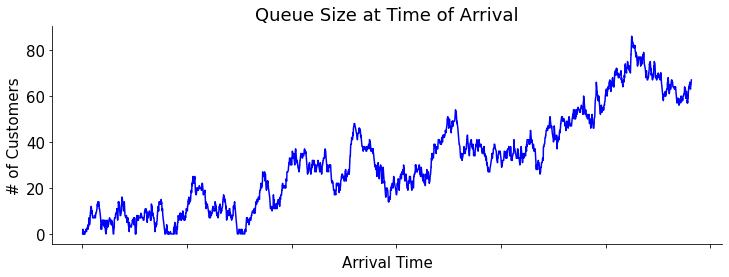

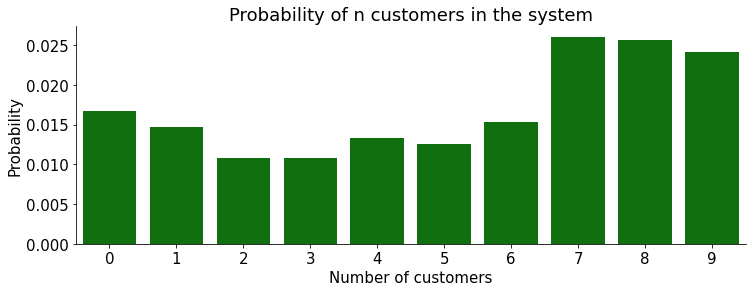

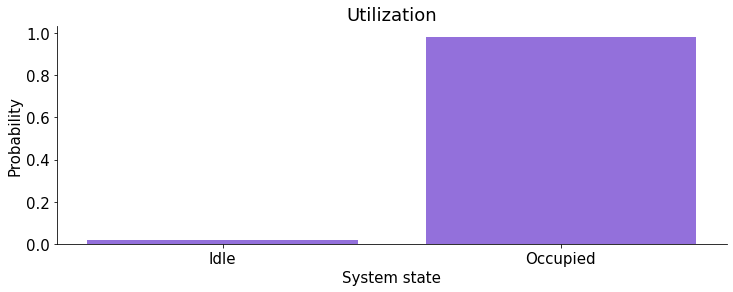

In [24]:
# plot the performance results
plot_perform(equal_model, eq_prob_df, eq_p0)

# Q5: Increase in Average Number of Donors by 5 Percent

In [25]:
# Create a function to create the simulations and append the results into the given lists
def change_results(l, mu, location):
    """ Create a simulation given the service rate and arrival rate. 
        Return the list of results.
        
    """
    
    N = ciw.create_network(
        arrival_distributions=[ciw.dists.Exponential(rate=l)],
        service_distributions=[ciw.dists.Exponential(rate=mu)],
        number_of_servers=[1])
    
    ciw.seed(0)

    Q = ciw.Simulation(N, tracker=ciw.trackers.SystemPopulation())
    Q.simulate_until_max_time(12)

    recs = Q.get_all_records()
    df = pd.DataFrame(recs)
    df.sort_values(by='arrival_date',inplace=True)
    df['inter_arrival'] = df.arrival_date - df.arrival_date.shift(1,fill_value=0)
    df['system_time'] = df.exit_date - df.arrival_date

    avg_inter_arrival_time = df['inter_arrival'].mean()

    avg_service_time = df['service_time'].mean()

    avg_system_time = df['system_time'].mean()

    coefficient_of_variation_arrival = df['inter_arrival'].mean()/df['inter_arrival'].std()

    coefficient_of_variation_service = df['service_time'].mean()/df['service_time'].std()

    avg_queue_size = df['queue_size_at_arrival'].mean()

    avg_wait_time = df['waiting_time'].mean()

    idel_time = 1- Q.transitive_nodes[0].server_utilisation

    utilization_rate = Q.transitive_nodes[0].server_utilisation

    # number of customers at any different time
    ts = [ts[0] for ts in Q.statetracker.history]
    n2 = [ts[1] for ts in Q.statetracker.history]

    timeline = pd.DataFrame(list(zip(ts, n2)), columns =['time', 'number_customers'])
    Tn = timeline.groupby(['number_customers'])['time'].count().to_frame('Freq').reset_index()


    # number of customers distribution
    ts = list(Q.statetracker.state_probabilities().keys())

    n2 = list(Q.statetracker.state_probabilities().values())

    prob_df = pd.DataFrame(list(zip(ts, n2)),
                   columns =['number_cust_system', 'probability_system'])

    p0 = prob_df['probability_system'][0]

    results = [avg_wait_time, avg_system_time, avg_queue_size, 
               avg_inter_arrival_time, avg_service_time, utilization_rate]
        
    results.append(location)
    
    return results

In [26]:
# Given
london_ar = 109.025 # London patient arrival rate
toronto_ar = 327.259 # Toronto patient arrival rate

london_sr = 110.047 # London patient service rate 
toronto_sr = 327.514 # Toronto patient service rate

In [27]:
# Create a dictionary to store the sr and ar for london and toronto
# Where the first value in represents the arrival rate (ar) and 
# the second value represents the service rate (sr)
# and the third value is the string of the location
# Our keys, 0 represents london while 1 represents toronto
rate_info = {0: [london_ar, london_sr, 'London'], 1: [toronto_ar, toronto_sr, 'Toronto']}

In [28]:
# Create a list of the different Percentage Increases we want to test
sr_change = [0.01, 0.02, 0.03, 0.04, 0.05]

In [29]:
# Create a list to store all the results 
results_list = []

In [30]:
# Use a for loop to run simulations with the change in rates for each location

# Outer loop will repeat the inner process for each location
for i in range(len(rate_info)):
    
    # Our inner loop will run the multiple simulations with each 
    # rate of change then store the results in the results dictionary
    for j in range(len(sr_change)):
        
        # Generate the new service rate with the percentage change 
        new_sr = rate_info[i][1]*(1+sr_change[j])
        
        # Set the variables for our simulation function
        l = rate_info[i][0] # our arrival rate
        mu = new_sr # our new service rate after change
        
        # our function sets c=1 and decimal = 4 so we do not need to change anything
        
        # Create a list to store the results
        # the first value will be the rate of change in our arrival rate
        results = [sr_change[j]]
        
        # Store the list of simulation results in a variable 
        sim_results = change_results(l, mu, rate_info[i][2])
        
        # For each result in the sim_results, append the result to the 
        # results list from before
        for k in sim_results:
            results.append(k)
        
        # Append the results to the final results list 
        results_list.append(results)

In [31]:
# Create a dataframe with our results
sr_results = pd.DataFrame(np.array(results_list)).rename(columns={0:'Percent Change of Service Rate', 
                                                                  1:'Average Wait Time', 
                                                                  2:'Average System Time', 
                                                                  3:'Average Queue Size', 
                                                                  4:'Mean Time Between Arrivals',
                                                                  5:'Average Service Time',
                                                                  6:'Utilization Rate',
                                                                  7:'Location'})

In [32]:
# Convert the strings into floats
columns = ['Percent Change of Service Rate', 'Average Wait Time', 'Average System Time', 
           'Average Queue Size', 'Mean Time Between Arrivals', 'Average Service Time', 'Utilization Rate']

for col in columns:
    sr_results[col] = sr_results[col].astype(float)
    
sr_results

,Percent Change of Service Rate,Average Wait Time,Average System Time,Average Queue Size,Mean Time Between Arrivals,Average Service Time,Utilization Rate,Location
0,0.01,0.202008,0.211103,22.334377,0.009295,0.009096,0.968610,London
1,0.02,0.120811,0.129878,13.518403,0.009224,0.009068,0.966075,London
2,0.03,0.119765,0.128713,13.232745,0.009301,0.008948,0.929344,London
3,0.04,0.092349,0.100999,10.557954,0.009521,0.008650,0.903609,London
4,0.05,0.098715,0.107485,11.191975,0.009288,0.008769,0.929009,London
5,0.01,0.104879,0.107922,34.955458,0.003067,0.003043,0.985535,Toronto
6,0.02,0.179814,0.182833,59.321995,0.003054,0.003020,0.984105,Toronto
7,0.03,0.137675,0.140703,45.945905,0.003016,0.003028,0.989084,Toronto
8,0.04,0.077555,0.080532,26.428645,0.003046,0.002978,0.965146,Toronto
9,0.05,0.133563,0.136532,45.254763,0.003029,0.002969,0.974609,Toronto


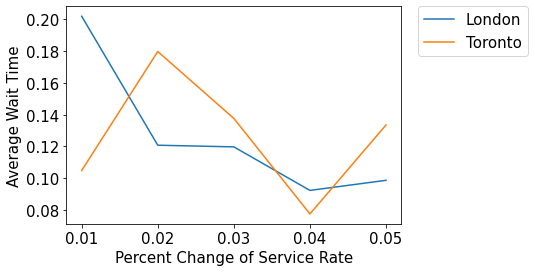

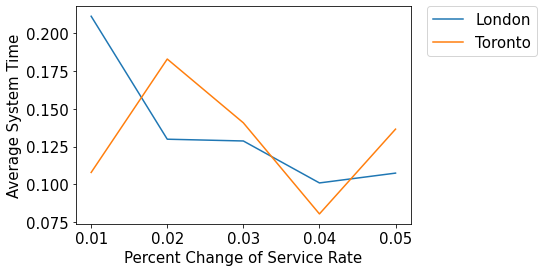

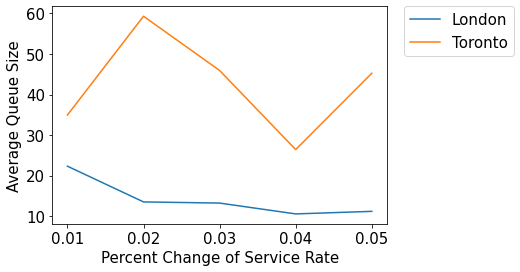

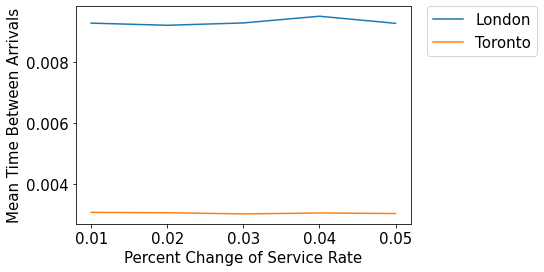

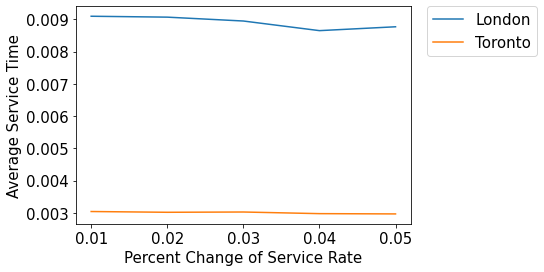

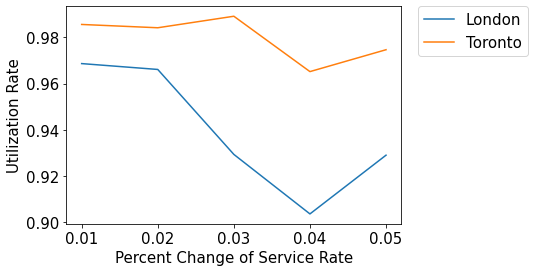

In [33]:
# Plot the Change in the performance results 

metrics = ['Average Wait Time', 'Average System Time', 
           'Average Queue Size', 'Mean Time Between Arrivals', 
           'Average Service Time', 'Utilization Rate']

for i in metrics:
    sns.lineplot(data=sr_results, x='Percent Change of Service Rate', y=i, hue='Location')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

# Q6: Increase in Average Arrival of Patients by 5 Percent

We will use the same process as the one we used in question 5 to see the results as we change the arrival rate for London and Toronto.

In [34]:
# Given
london_ar = 109.025 # London patient arrival rate
toronto_ar = 327.259 # Toronto patient arrival rate

london_sr = 110.047 # London patient service rate 
toronto_sr = 327.514 # Toronto patient service rate

In [35]:
# Show the given information
# Where the first value in represents the arrival rate (ar) and 
# the second value represents the service rate (sr)
# and the third value is the string of the location
# Our keys, 0 represents london while 1 represents toronto
print(rate_info)

{0: [109.025, 110.047, 'London'], 1: [327.259, 327.514, 'Toronto']}


In [36]:
# Create a list of the different Percentage Increases we want to test
ar_change = [0.01, 0.02, 0.03, 0.04, 0.05]

In [37]:
# Create a list to store all the results 
results_list = []

In [38]:
# Use a for loop to run simulations with the change in rates for each location

# Outer loop will repeat the inner process for each location
for i in range(len(rate_info)):
    
    # Our inner loop will run the multiple simulations with each 
    # rate of change then store the results in the results dictionary
    for j in range(len(sr_change)):
        
        # Generate the new arrival rate with the percentage change 
        new_ar = rate_info[i][0]*(1+sr_change[j])
        
        # Set the variables for our simulation function
        l = new_ar # our new arrival rate
        mu = rate_info[i][1] # our service rate 
        
        # our function sets c=1 and decimal = 4 so we do not need to change anything
        
        # Create a list to store the results
        # the first value will be the rate of change in our arrival rate
        results = [sr_change[j]]
        
        # Store the list of simulation results in a variable 
        sim_results = change_results(l, mu, rate_info[i][2])
        
        # For each result in the sim_results, append the result to the 
        # results list from before
        for k in sim_results:
            results.append(k)
        
        # Append the results to the final results list 
        results_list.append(results)

In [39]:
# Create a dataframe with our results
ar_results = pd.DataFrame(np.array(results_list)).rename(columns={0:'Percent Change', 
                                                                  1:'Average Wait Time', 
                                                                  2:'Average System Time', 
                                                                  3:'Average Queue Size', 
                                                                  4:'Mean Time Between Arrivals',
                                                                  5:'Average Service Time',
                                                                  6:'Utilization Rate',
                                                                  7:'Location'})

In [40]:
# Convert the strings into floats
columns = ['Percent Change', 'Average Wait Time', 'Average System Time', 'Average Queue Size',
           'Mean Time Between Arrivals', 'Average Service Time', 'Utilization Rate']

for col in columns:
    ar_results[col] = ar_results[col].astype(float)
    
ar_results

,Percent Change,Average Wait Time,Average System Time,Average Queue Size,Mean Time Between Arrivals,Average Service Time,Utilization Rate,Location
0,0.01,0.132281,0.141381,14.796047,0.009318,0.009100,0.959464,London
1,0.02,0.262791,0.271985,28.504334,0.009144,0.009193,0.973018,London
2,0.03,0.121612,0.130697,14.049257,0.009158,0.009085,0.970133,London
3,0.04,0.448508,0.457663,49.560676,0.008913,0.009155,0.993364,London
4,0.05,0.312275,0.321377,34.810665,0.008955,0.009102,0.981691,London
5,0.01,0.254960,0.258052,82.404261,0.003032,0.003092,0.980097,Toronto
6,0.02,0.144886,0.147964,46.689835,0.003006,0.003078,0.981854,Toronto
7,0.03,0.233053,0.236129,76.755727,0.002982,0.003076,0.995990,Toronto
8,0.04,0.193299,0.196317,64.525492,0.002999,0.003017,0.996517,Toronto
9,0.05,0.198947,0.201969,66.507071,0.002976,0.003021,0.997479,Toronto


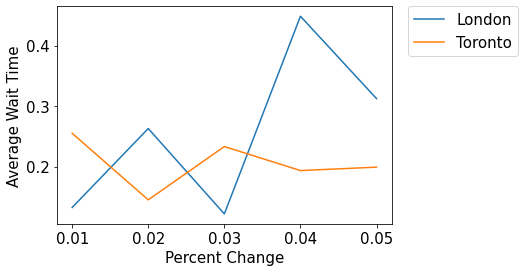

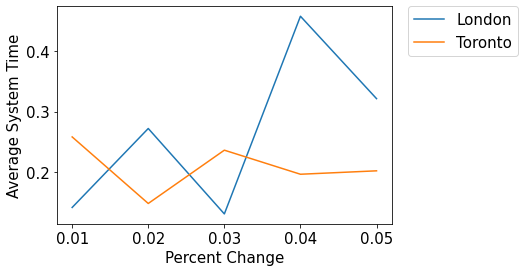

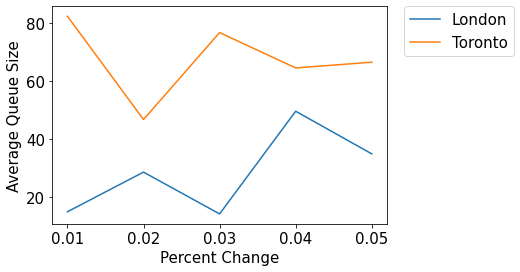

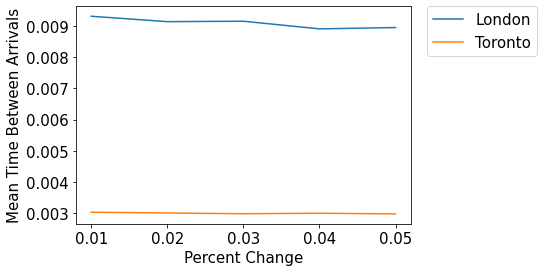

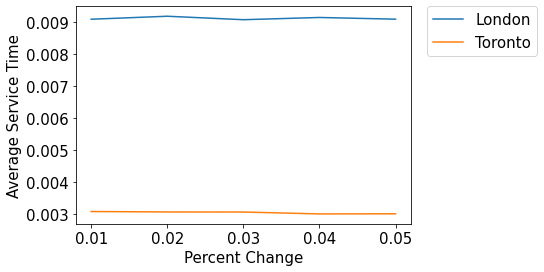

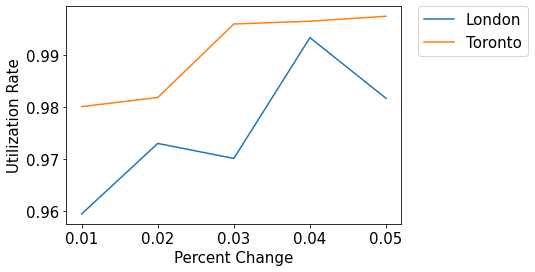

In [41]:
# Plot the Change in the performance results 

metrics = ['Average Wait Time', 'Average System Time', 
           'Average Queue Size', 'Mean Time Between Arrivals', 
           'Average Service Time', 'Utilization Rate']

for i in metrics:
    sns.lineplot(data=ar_results, x='Percent Change', y=i, hue='Location')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

# Q7: Evaluate performance of change in coefficient variation

Output: 
 Servers : 2 
 Coefficient of Variation Time between Arrival Time:   1.3918 
 Coefficient of Variation Service Time:   1.4167 
 Mean Time Between Arrivals:  0.0047 
 Mean Service Time:  0.0093 
 Utilization (c):  0.9941 
 Expected wait time in line (Wq): 0.1248 
 Expected time spent on the system (Ws): 0.1341 
 Expected number of customers in line (Lq): 28.2686 
 Probability of No customers in system(P0):  0.0038 



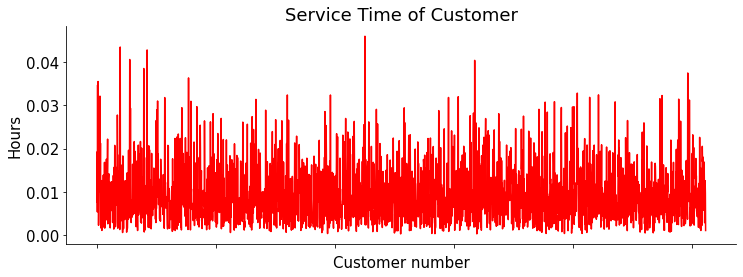

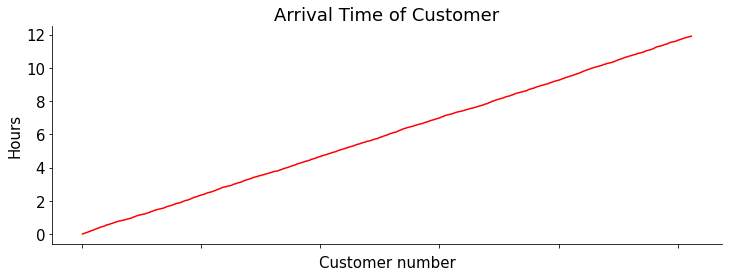

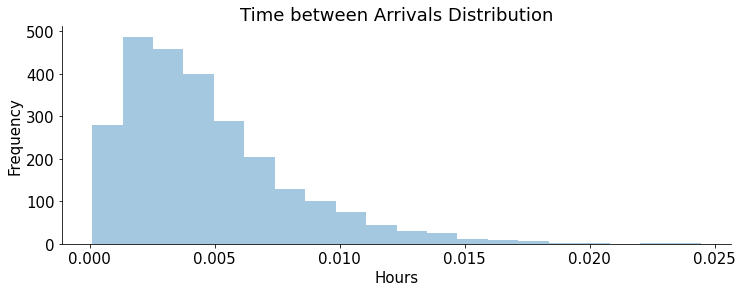

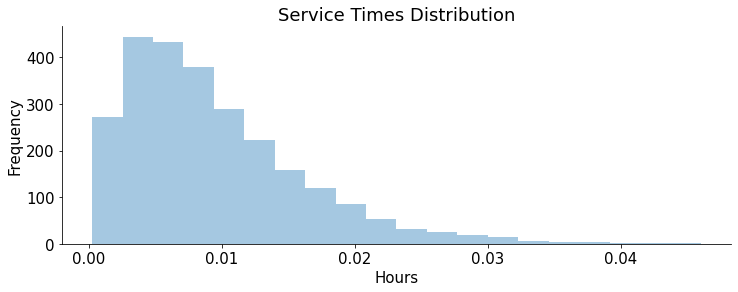

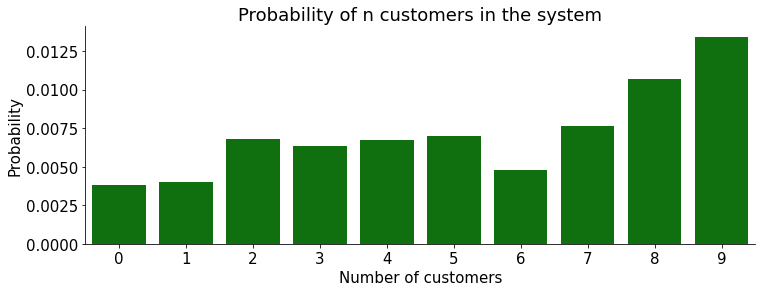

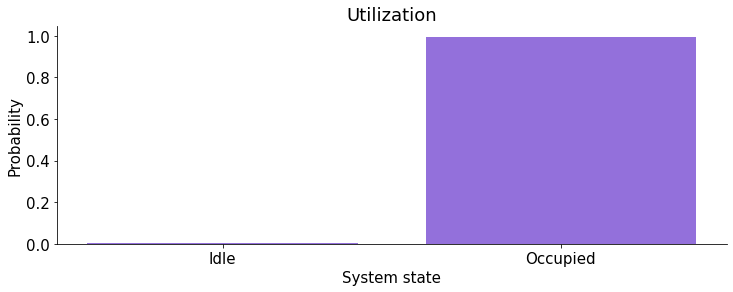

In [42]:

# We will create a function to increase coefficient variation
# gamma function is used and The gamma and exponential distributions are equivalent when the gamma distribution has a shape value of 1.
# shape value equals the number of events and increase in value of shape represent increase in variation
service_arrival_london = 436.284
service_service_london = 218.78
c = 2
decimal = 4

N = ciw.create_network(
    arrival_distributions=[ciw.dists.Gamma(shape = 2, scale=1/436.284)],
    service_distributions=[ciw.dists.Gamma(shape = 2, scale=1/218.78)],
    number_of_servers=[c])
ciw.seed(0)
Q = ciw.Simulation(N, tracker=ciw.trackers.SystemPopulation())
Q.simulate_until_max_time(12)

recs = Q.get_all_records()
df = pd.DataFrame(recs)
df.sort_values(by='arrival_date',inplace=True)
df['inter_arrival'] = df.arrival_date - df.arrival_date.shift(1,fill_value=0)
df['system_time'] = df.exit_date - df.arrival_date

df[['id_number','server_id','arrival_date','waiting_time','service_start_date','server_id','service_time','service_end_date','exit_date','queue_size_at_arrival','queue_size_at_departure']]

avg_inter_arrival_time = df['inter_arrival'].mean()

avg_service_time = df['service_time'].mean()

avg_system_time = df['system_time'].mean()

coefficient_of_variation_arrival = df['inter_arrival'].mean()/df['inter_arrival'].std()

coefficient_of_variation_service = df['service_time'].mean()/df['service_time'].std()

avg_queue_size = df['queue_size_at_arrival'].mean()

avg_wait_time = df['waiting_time'].mean()

idel_time = 1- Q.transitive_nodes[0].server_utilisation

utilization_rate = Q.transitive_nodes[0].server_utilisation

# number of customers at any different time
ts = [ts[0] for ts in Q.statetracker.history]
n2 = [ts[1] for ts in Q.statetracker.history]

timeline = pd.DataFrame(list(zip(ts, n2)), columns =['time', 'number_customers'])
Tn = timeline.groupby(['number_customers'])['time'].count().to_frame('Freq').reset_index()


avg_inter_arrival_time = df['inter_arrival'].mean()

avg_service_time = df['service_time'].mean()

avg_system_time = df['system_time'].mean()

coefficient_of_variation_arrival = df['inter_arrival'].mean()/df['inter_arrival'].std()

coefficient_of_variation_service = df['service_time'].mean()/df['service_time'].std()

avg_queue_size = df['queue_size_at_arrival'].mean()

avg_wait_time = df['waiting_time'].mean()

idel_time = 1- Q.transitive_nodes[0].server_utilisation

utilization_rate = Q.transitive_nodes[0].server_utilisation

# number of customers at any different time
ts = [ts[0] for ts in Q.statetracker.history]
n2 = [ts[1] for ts in Q.statetracker.history]

timeline = pd.DataFrame(list(zip(ts, n2)), columns =['time', 'number_customers'])
Tn = timeline.groupby(['number_customers'])['time'].count().to_frame('Freq').reset_index()


# number of customers distribution
ts = list(Q.statetracker.state_probabilities().keys())

n2 = list(Q.statetracker.state_probabilities().values())

prob_df = pd.DataFrame(list(zip(ts, n2)),
               columns =['number_cust_system', 'probability_system'])

p0 = prob_df['probability_system'][0]

print('Output:','\n',
     'Servers : '+str(c),'\n',
     'Coefficient of Variation Time between Arrival Time:  ' ,str(round(coefficient_of_variation_arrival,decimal)),'\n',
     'Coefficient of Variation Service Time:  ' ,str(round(coefficient_of_variation_service,decimal)),'\n',
     'Mean Time Between Arrivals: ',str(round(avg_inter_arrival_time,decimal)),'\n',
     'Mean Service Time: ',str(round(avg_service_time,decimal)),'\n'
     ' Utilization (c): ', str(round(utilization_rate,decimal)),'\n',
     'Expected wait time in line (Wq):',str(round(avg_wait_time,decimal)),'\n',
     'Expected time spent on the system (Ws):',str(round(avg_system_time,decimal)),'\n',
     'Expected number of customers in line (Lq):',str(round(avg_queue_size,decimal)),'\n',
     'Probability of No customers in system(P0): ', str(round(p0,decimal)),'\n'
)

#plotting Wait times
plt.figure(figsize=(12,4))
sns.lineplot(x=df['id_number'],y=df['service_time'],color='red').set(xticklabels=[])
plt.xlabel('Customer number')
plt.ylabel('Hours')
plt.title('Service Time of Customer')
sns.despine()
plt.show()

#plotting Arrival times
plt.figure(figsize=(12,4))
sns.lineplot(x=df['id_number'],y=df['arrival_date'],color='red').set(xticklabels=[])
plt.xlabel('Customer number')
plt.ylabel('Hours')
plt.title('Arrival Time of Customer')
sns.despine()
plt.show()

plt.figure(figsize=(12,4))
sns.distplot(df['inter_arrival'],kde=False,bins=20)
plt.title('Time between Arrivals Distribution')
plt.xlabel('Hours')
plt.ylabel('Frequency')
sns.despine()
plt.show()

#service time distribution plot
plt.figure(figsize=(12,4))
sns.distplot(df['service_time'],kde=False,bins=20)
plt.title('Service Times Distribution')
plt.xlabel('Hours')
plt.ylabel('Frequency')
sns.despine()
plt.show()

plt.figure(figsize=(12,4))
sns.barplot(x=prob_df.iloc[0:10,:]['number_cust_system'],y=prob_df.iloc[0:10,:]['probability_system'],color='g')
plt.title('Probability of n customers in the system')
plt.xlabel('Number of customers')
plt.ylabel('Probability')
sns.despine()
plt.show()

plt.figure(figsize=(12,4))
plt.bar(['Idle','Occupied'],[p0,1-p0],color='mediumpurple')
plt.title('Utilization')
plt.xlabel('System state')
plt.ylabel('Probability')
sns.despine()
plt.show()


Output: 
 Servers : 2 
 Coefficient of Variation Time between Arrival Time:   1.7434 
 Coefficient of Variation Service Time:   1.7257 
 Mean Time Between Arrivals:  0.007 
 Mean Service Time:  0.0138 
 Utilization (c):  0.9725 
 Expected wait time in line (Wq): 0.0723 
 Expected time spent on the system (Ws): 0.086 
 Expected number of customers in line (Lq): 11.8796 
 Probability of No customers in system(P0):  0.0108 



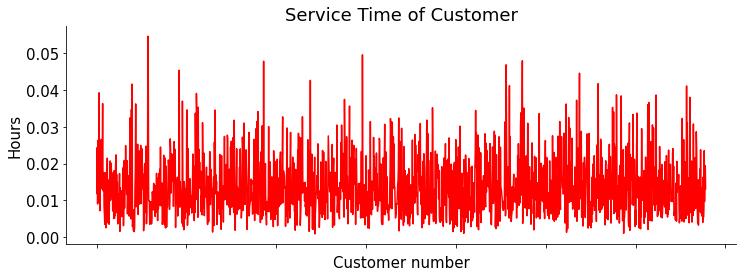

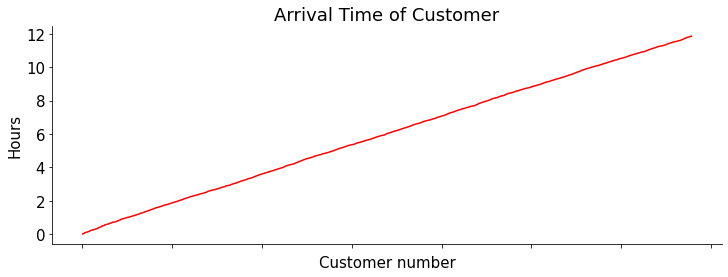

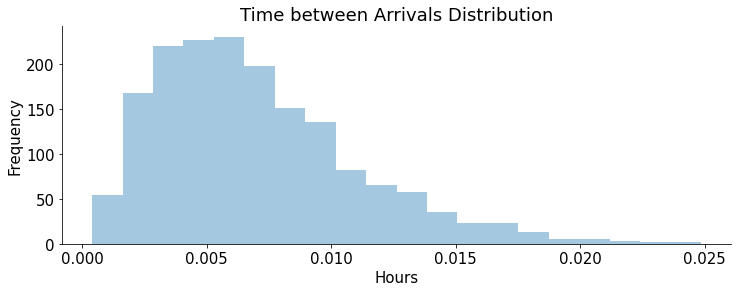

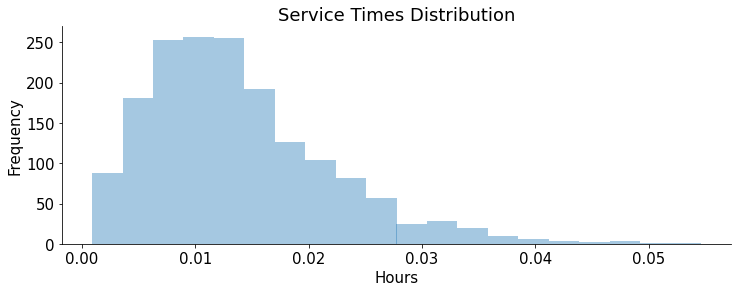

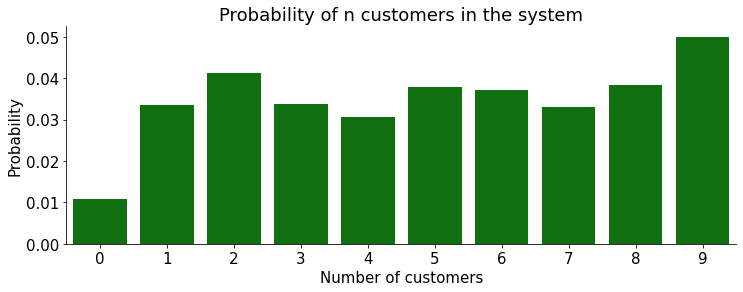

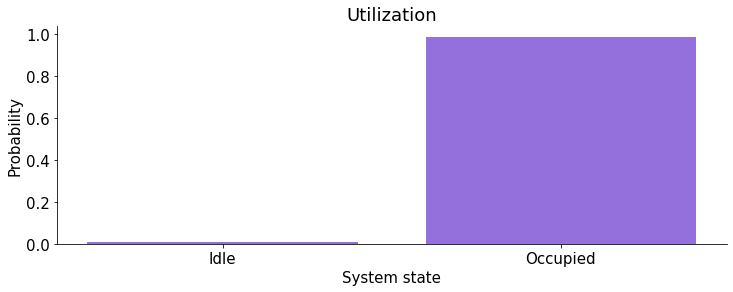

In [43]:
# for shape = 3
service_arrival_london = 436.284
service_service_london = 218.78
c = 2
decimal = 4

N = ciw.create_network(
    arrival_distributions=[ciw.dists.Gamma(shape = 3, scale=1/436.284)],
    service_distributions=[ciw.dists.Gamma(shape = 3, scale=1/218.78)],
    number_of_servers=[c])
ciw.seed(0)
Q = ciw.Simulation(N, tracker=ciw.trackers.SystemPopulation())
Q.simulate_until_max_time(12)

recs = Q.get_all_records()
df = pd.DataFrame(recs)
df.sort_values(by='arrival_date',inplace=True)
df['inter_arrival'] = df.arrival_date - df.arrival_date.shift(1,fill_value=0)
df['system_time'] = df.exit_date - df.arrival_date

df[['id_number','server_id','arrival_date','waiting_time','service_start_date','server_id','service_time','service_end_date','exit_date','queue_size_at_arrival','queue_size_at_departure']]


avg_inter_arrival_time = df['inter_arrival'].mean()

avg_service_time = df['service_time'].mean()

avg_system_time = df['system_time'].mean()

coefficient_of_variation_arrival = df['inter_arrival'].mean()/df['inter_arrival'].std()

coefficient_of_variation_service = df['service_time'].mean()/df['service_time'].std()

avg_queue_size = df['queue_size_at_arrival'].mean()

avg_wait_time = df['waiting_time'].mean()

idel_time = 1- Q.transitive_nodes[0].server_utilisation

utilization_rate = Q.transitive_nodes[0].server_utilisation
avg_inter_arrival_time = df['inter_arrival'].mean()

avg_service_time = df['service_time'].mean()

avg_system_time = df['system_time'].mean()

coefficient_of_variation_arrival = df['inter_arrival'].mean()/df['inter_arrival'].std()

coefficient_of_variation_service = df['service_time'].mean()/df['service_time'].std()

avg_queue_size = df['queue_size_at_arrival'].mean()

avg_wait_time = df['waiting_time'].mean()

idel_time = 1- Q.transitive_nodes[0].server_utilisation

utilization_rate = Q.transitive_nodes[0].server_utilisation

# number of customers at any different time
ts = [ts[0] for ts in Q.statetracker.history]
n2 = [ts[1] for ts in Q.statetracker.history]

timeline = pd.DataFrame(list(zip(ts, n2)), columns =['time', 'number_customers'])
Tn = timeline.groupby(['number_customers'])['time'].count().to_frame('Freq').reset_index()

# number of customers distribution
ts = list(Q.statetracker.state_probabilities().keys())

n2 = list(Q.statetracker.state_probabilities().values())

prob_df = pd.DataFrame(list(zip(ts, n2)),
               columns =['number_cust_system', 'probability_system'])

p0 = prob_df['probability_system'][0]

print('Output:','\n',
     'Servers : '+str(c),'\n',
     'Coefficient of Variation Time between Arrival Time:  ' ,str(round(coefficient_of_variation_arrival,decimal)),'\n',
     'Coefficient of Variation Service Time:  ' ,str(round(coefficient_of_variation_service,decimal)),'\n',
     'Mean Time Between Arrivals: ',str(round(avg_inter_arrival_time,decimal)),'\n',
     'Mean Service Time: ',str(round(avg_service_time,decimal)),'\n'
     ' Utilization (c): ', str(round(utilization_rate,decimal)),'\n',
     'Expected wait time in line (Wq):',str(round(avg_wait_time,decimal)),'\n',
     'Expected time spent on the system (Ws):',str(round(avg_system_time,decimal)),'\n',
     'Expected number of customers in line (Lq):',str(round(avg_queue_size,decimal)),'\n',
     'Probability of No customers in system(P0): ', str(round(p0,decimal)),'\n'
)

#plotting Wait times
plt.figure(figsize=(12,4))
sns.lineplot(x=df['id_number'],y=df['service_time'],color='red').set(xticklabels=[])
plt.xlabel('Customer number')
plt.ylabel('Hours')
plt.title('Service Time of Customer')
sns.despine()
plt.show()

#plotting Arrival times
plt.figure(figsize=(12,4))
sns.lineplot(x=df['id_number'],y=df['arrival_date'],color='red').set(xticklabels=[])
plt.xlabel('Customer number')
plt.ylabel('Hours')
plt.title('Arrival Time of Customer')
sns.despine()
plt.show()

plt.figure(figsize=(12,4))
sns.distplot(df['inter_arrival'],kde=False,bins=20)
plt.title('Time between Arrivals Distribution')
plt.xlabel('Hours')
plt.ylabel('Frequency')
sns.despine()
plt.show()

#service time distribution plot
plt.figure(figsize=(12,4))
sns.distplot(df['service_time'],kde=False,bins=20)
plt.title('Service Times Distribution')
plt.xlabel('Hours')
plt.ylabel('Frequency')
sns.despine()
plt.show()

plt.figure(figsize=(12,4))
sns.barplot(x=prob_df.iloc[0:10,:]['number_cust_system'],y=prob_df.iloc[0:10,:]['probability_system'],color='g')
plt.title('Probability of n customers in the system')
plt.xlabel('Number of customers')
plt.ylabel('Probability')
sns.despine()
plt.show()


plt.figure(figsize=(12,4))
plt.bar(['Idle','Occupied'],[p0,1-p0],color='mediumpurple')
plt.title('Utilization')
plt.xlabel('System state')
plt.ylabel('Probability')
sns.despine()
plt.show()


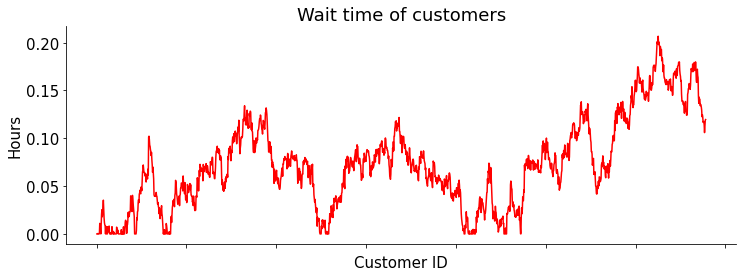

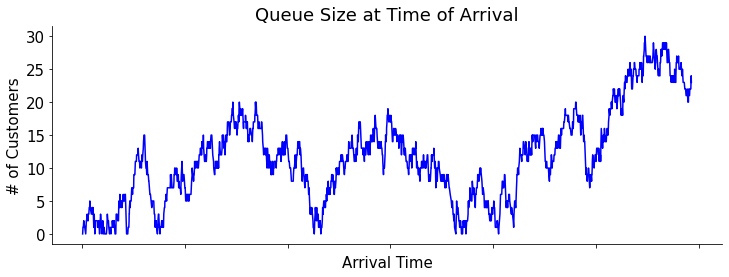

In [44]:
#plot waiting time and number of customers to compare
plt.figure(figsize=(12,4))
sns.lineplot(x=df['id_number'],y=df['waiting_time'],color='red').set(xticklabels=[])
plt.xlabel('Customer ID')
plt.ylabel('Hours')
plt.title('Wait time of customers')
sns.despine()
plt.show()

plt.figure(figsize=(12,4))
sns.lineplot(x=df['arrival_date'],y=df['queue_size_at_arrival'],color='blue').set(xticklabels=[])
plt.xlabel('Arrival Time')
plt.ylabel('# of Customers')
plt.title('Queue Size at Time of Arrival')
sns.despine()
plt.show()
